## Integrated Historical CO$_{2}$ Flux

What is the spread on integrated global CO$_{2}$ and Southern Ocean CO$_{2}$ flux? 

1. CMIP6 multi-model spread (fully coupled ESMs)
2. OMIP multi-model spread (reconstructions)

This is motivated by Nikki's figure for the IPCC:

![](https://i.ibb.co/LppydBD/Screen-Shot-2019-07-31-at-10-02-22-AM.png)

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import esm_analysis as ea
from glob import glob
import proplot as plot
import matplotlib.pyplot as plt
import yaml
from scipy.io import loadmat
from matplotlib.patches import Rectangle

/global/homes/b/bradyrx/miniconda3/envs/python3/lib/python3.7/site-packages/proplot/projs.py:368: ProPlotWarning: Cartopy projection(s) eck1, eck2, eck3, eck4, eck5, eck6, eqdc, eqearth are unavailable. Consider updating to cartopy>=0.17.0.


In [2]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Process CMIP6 Output

Here I just go through the whole YAML file and integrate global CO2 flux for any members available.

In [340]:
# open YAML file with available models
with open('cmip6_fgco2.yaml') as f:
    fgco2_in = yaml.safe_load(f)

**Process all members by integrating**

In [348]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [ ]:
basepath = '/global/cscratch1/sd/cmip6/CMIP6/CMIP'
# Loop through institutes
for inst in fgco2_in:
    # Loop through models
    for model in fgco2_in[inst]:
        print(f'Institute: {inst}; Model: {model}...')
        model_attrs = fgco2_in[inst][model]       
        grid = model_attrs['grid']
        # Loop through ensembles (if there are multiple)
        for e in model_attrs['ensemble']:
            physics = model_attrs['ensemble'][e]['physics'] # physics number for ripf
            forcing = model_attrs['ensemble'][e]['forcing'] # forcing number for ripf
            members = model_attrs['ensemble'][e]['members']
            # Loop through individual ensemble members
            for m in members:
                print(f'Member {m}...')
                filepath = f'{basepath}/{inst}/{model}/historical/r{m}i1p{physics}f{forcing}/Omon/fgco2/{grid}/'
                version = np.sort(glob(f'{filepath}/*'))[-1].split('/')[-1] # Grabs the most recent version
                filepath += (version + '/')
                # Load in FGCO2
                ds = xr.open_mfdataset(filepath + '*.nc')['fgco2'].load()
                # Load in cell area
                areacello = xr.open_dataset(f'/global/cscratch1/sd/bradyrx/areacello/areacello_{model}.nc')['areacello']
                # combine
                ds = ds.reset_coords(drop=True)
                # units are kg / m2 / s
                lat = model_attrs['lat']
                lon = model_attrs['lon']
                print('Integrating...')
                # SOUTHERN OCEAN ONLY (can comment out)
                latmask = ds[lat].load()
                ds = ds.where(latmask <= -35, drop=True)
                areacello = areacello.where(latmask <=-35, drop=True)
                fgco2_int = (ds * areacello).sum([lat, lon])
                fgco2_int = ea.temporal.to_annual(fgco2_int, calendar=model_attrs['calendar']).rename('fgco2').load()
                FACTOR = eval(model_attrs['conversion'])
                fgco2_int *= FACTOR
                fgco2_int.attrs['description'] = 'Southern Ocean integral (<= -35S) of air-sea CO2 flux; annual averages.'
                fgco2_int.attrs['units'] = 'Pg C / yr'
                fgco2_int.attrs['member'] = f'r{m}i1p{physics}f{forcing}'
                fgco2_int.attrs['model'] = model
                fgco2_int.attrs['direction'] = 'Negative is uptake by the ocean.'
                fgco2_int.attrs['time-range'] = '1850 to 2014'
                fgco2_int.attrs['version'] = version
                print('Saving...')
                fileout = f'{model}_r{m}i1p{physics}f{forcing}_southern_ocean_int'
                fgco2_int.to_dataset().to_netcdf(f'/global/homes/b/bradyrx/CMIP6_hackathon/processed/CMIP6_SO/{fileout}.nc')

## Process OMIP Output

This processes the available omip1/omip2 output for CMIP6. I only have CNRM and IPSL from ESGF + the NCAR runs through Cheyenne.

CNRM

```python
ds = xr.open_dataset('/global/homes/b/bradyrx/scratch/OMIP/fgco2_Omon_CNRM-ESM2-1_omip1_r1i1p1f2_gn_195001-200912.nc')['fgco2']
areacello = xr.open_dataset('/global/homes/b/bradyrx/scratch/areacello/areacello_CNRM-ESM2-1.nc')['areacello']
fgco2_int = (ds * areacello).sum(['y', 'x'])
fgco2_int = ea.temporal.to_annual(fgco2_int, calendar='noleap').rename('fgco2')
FACTOR = -1*60*60*24*365.25/1e12
fgco2_int *= FACTOR
fgco2_int.attrs['description'] = 'Global integral of air-sea CO2 flux; annual averages'
fgco2_int.attrs['units'] = 'Pg C / yr'
```


IPSL

```python
ds = xr.open_mfdataset('/global/homes/b/bradyrx/scratch/OMIP/*IPSL*.nc', concat_dim='member')['fgco2']
areacello = xr.open_dataset('/global/homes/b/bradyrx/scratch/areacello/areacello_IPSL-CM6A-LR.nc')['areacello']
ds = ds.reset_coords(drop=True)
ds = ds.sel(time=slice('1950', '2010'))
ds = (ds*areacello).sum(['x','y'])
ds = ea.temporal.to_annual(ds, calendar='noleap').rename('fgco2')
ds *= -1*60*60*24*365.25/1e12
ds = ds.load()
# Second member seems to be fixed carbon.
# ds.isel(member=0).to_dataset().to_netcdf('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/IPSL-CM6A-LR_195001-200912.nc')
```

NCAR -- omip1, realization 1

```python
basepath = '/global/cscratch1/sd/bradyrx/'
ds = xr.open_dataset(basepath + 'OMIP/fgco2_Omon_CESM2_omip1_r1i1p1f1_gn_024901-031012.nc')['fgco2']
areacello = xr.open_dataset(basepath + 'areacello/areacello_CESM2.nc')['areacello']
fgco2_int = (ds * areacello).sum(['nlat', 'nlon'])
fgco2_int['time'] = np.arange('1948-01', '2010-01', dtype='datetime64[M]')
fgco2_int = ea.temporal.to_annual(fgco2_int, calendar='noleap').rename('fgco2')
FACTOR = -1*60*60*24*365/1e12
fgco2_int *= FACTOR
fgco2_int.attrs['description'] = 'Global integral of air-sea CO2 flux; annual averages'
fgco2_int.attrs['units'] = 'Pg C / yr'
```


NCAR -- omip1, realization 2

```python
ds = xr.open_dataset(basepath + 'OMIP/fgco2_Omon_CESM2_omip1_r2i1p1f1_gn_031101-037212.nc')['fgco2']
areacello = xr.open_dataset(basepath + 'areacello/areacello_CESM2.nc')['areacello']
fgco2_int = (ds * areacello).sum(['nlat', 'nlon'])
fgco2_int['time'] = np.arange('1948-01', '2010-01', dtype='datetime64[M]')
fgco2_int = ea.temporal.to_annual(fgco2_int, calendar='noleap').rename('fgco2')
FACTOR = -1*60*60*24*365/1e12
fgco2_int *= FACTOR
fgco2_int.attrs['description'] = 'Global integral of air-sea CO2 flux; annual averages'
fgco2_int.attrs['units'] = 'Pg C / yr'
```

NCAR -- omip2

```python
ds = xr.open_dataset(basepath + 'OMIP/fgco2_Omon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc')['fgco2']
areacello = xr.open_dataset(basepath + 'areacello/areacello_CESM2.nc')['areacello']
fgco2_int = (ds * areacello).sum(['nlat', 'nlon'])
fgco2_int['time'] = np.arange('1958-01', '2019-01', dtype='datetime64[M]')
fgco2_int = ea.temporal.to_annual(fgco2_int, calendar='noleap').rename('fgco2')
FACTOR = -1*60*60*24*365/1e12
fgco2_int *= FACTOR
fgco2_int.attrs['description'] = 'Global integral of air-sea CO2 flux; annual averages'
fgco2_int.attrs['units'] = 'Pg C / yr'
```

# Reproduce Nikki IPCC Figure

GCB runs from 1959 - 2017

In [388]:
# for preindustrial outgassing in PgC/yr
RIVER_CORRECTION = 0.45 

# open YAML file with observational time ranges
with open('ipcc_observations.yaml') as f:
    ipcc = yaml.safe_load(f)

In [389]:
# Reconstructions
GCB = ['cesm', 'cnrm', 'ipsl', 'mit', 'mpi', 'noresm', 'planktom']
basepath = '/global/homes/b/bradyrx/scratch/nikki_IPCC/GCB/mat'
GCB_filepaths = [f'{basepath}/{i}.mat' for i in GCB]

# Observational-Estimates
SOCOM = ['somffn_global', 'jena_global', 'jma_global',
         'csir_global', 'niesnn_global', 'lsce_global']
SOCOM_filepaths = [f'{basepath}/{i}.mat' for i in SOCOM]

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100

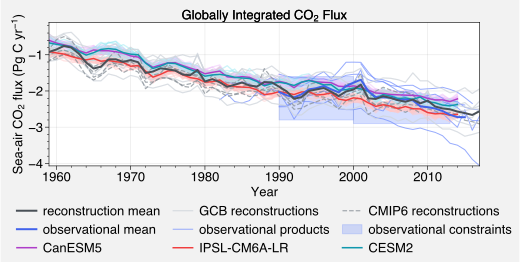

In [390]:
### xr.set_options(arithmetic_join="outer")

plot.rc.small = 13
plot.rc.large = 13
plot.rc['legend.frameon'] = False

f, ax = plot.subplots(axwidth=6, aspect=3, legend='b')


# ==================
# SOCOM Observations
# ==================
basepath = '/global/homes/b/bradyrx/scratch/nikki_IPCC/SOCOM/mat'
mmm = 0
for i, obs in enumerate(ipcc['observations']):
    filename = f'{basepath}/{obs}_global.mat'
    ds = xr.DataArray(loadmat(filename)[f'{obs}_global'].squeeze(),
                      dims='time') - RIVER_CORRECTION
    time_range = ipcc['observations'][obs]['time_range']
    ds['time'] = np.arange(time_range[0], time_range[-1] + 1)
    obsH, = ds.plot(color='indigo4', ax=ax, linewidth=1, alpha=0.75,
            label='observational products')
    
    # Finding multi-model mean
    if obs != 'lsce':
        ds = ds.sel(time=slice(1990, 2015))
        mmm += ds
obs_meanH, = (mmm / 5).plot(color='indigo7', ax=ax, zorder=5, linewidth=2,
               label='observational mean')

# =========================
# Observational Constraints
# =========================
# First constraint from Nikki's code.
constraint_1H = ax.add_patch(Rectangle((1990, -2.8), 10, 1.2, color='indigo4', alpha=0.3, 
                             label='observational constraints'))
# Gruber paper
# 2000 - 2013. 2.6 +/- 0.3 PgC/yr
ax.add_patch(Rectangle((2000, -2.9), 13, 0.6, color='indigo4', alpha=0.3))

# ========================
# OMIP: Old ones and CMIP6 
# ========================
# Zero array spanning the whole possible time series of 1948 - 2018
mmm_omip = xr.DataArray(np.zeros(71), dims=['time'],)
mmm_omip['time'] = np.arange(1948, 2019, 1)
counter = xr.zeros_like(mmm_omip) # This will count how much to divide by.

# GCB Results
for i, run in enumerate(GCB_filepaths):
    # GCB with negative being uptake
    ds = (xr.DataArray(loadmat(GCB_filepaths[i])[GCB[i]].squeeze(),
                      dims='time') * -1)
    ds['time'] = np.arange(1959, 2018)
    old_oH, = ds.plot(color='gray4', ax=ax, linewidth=1.25, label='GCB reconstructions',
                      alpha=0.75)
    
    # Finding multi-model mean
    # Expands index to full time series and fills empties with zeros
    mmm_omip = mmm_omip + ds.reindex_like(mmm_omip, fill_value=0)
    # Places ones where the dataset has values
    counter = counter + xr.ones_like(ds).reindex_like(mmm_omip, fill_value=0)

# OMIP from CMIP6
# Average of the two CMIP6 OMIP1's, since they are virtually identical
ncar_omip1 = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/CESM2_omip1_*.nc',
                               concat_dim='member')
new_oH, = ncar_omip1.mean('member').fgco2.plot(color='gray6', linestyle='--', ax=ax,
                                     linewidth=1.25, label='CMIP6 reconstructions',
                                               alpha=0.75)

# NCAR OMIP2 (just uses JRA forcing)
ncar_omip2 = xr.open_dataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/CESM2_omip2_r1i1p1f1_1958-2018.nc')
ncar_omip2.fgco2.plot(color='gray6', linestyle='--', ax=ax,
                      linewidth=1.25, alpha=0.75)

# IPSL/CNRM
other_omip1 = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/*_1950-2009.nc',
                                concat_dim='member')
other_omip1.fgco2.plot(hue='member', color='gray6', linestyle='--', ax=ax,
                       linewidth=1.25, add_legend=False, alpha=0.75)

# Add in CMIP6 reconstructions to multi-model mean.
mmm_omip = mmm_omip \
    + ncar_omip1.mean('member').rename({'year': 'time'}).fgco2.reindex_like(mmm_omip, fill_value=0) \
    + ncar_omip2.rename({'year': 'time'}).fgco2.reindex_like(mmm_omip, fill_value=0) \
    + other_omip1.isel(member=0).rename({'year': 'time'}).fgco2.reindex_like(mmm_omip, fill_value=0) \
    + other_omip1.isel(member=1).rename({'year': 'time'}).fgco2.reindex_like(mmm_omip, fill_value=0)

counter = counter + xr.ones_like(ncar_omip1.mean('member').rename({'year': 'time'}).fgco2).reindex_like(mmm_omip, fill_value=0)
counter = counter + xr.ones_like(ncar_omip2.rename({'year': 'time'}).fgco2).reindex_like(mmm_omip, fill_value=0)
counter = counter + xr.ones_like(other_omip1.isel(member=0).rename({'year': 'time'}).fgco2).reindex_like(mmm_omip, fill_value=0)
counter = counter + xr.ones_like(other_omip1.isel(member=1).rename({'year': 'time'}).fgco2).reindex_like(mmm_omip, fill_value=0)
oH, = (mmm_omip / counter).plot(color='gray7', ax=ax, zorder=5, linewidth=2,
                         label='reconstruction mean')

# ================================
# CMIP6 Ensembles and Realizations 
# ================================

# [1] CanESM5 ensemble (25 members, physics 1)
canesm = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/CMIP6/CanESM5*p1*.nc', 
                           concat_dim='member')['fgco2'].sel(year=slice(1959, 2017))
canesm.plot(hue='member', add_legend=False, color='grape2', ax=ax, alpha=0.5, zorder=1)
canH, = canesm.mean('member').plot(color='grape7', ax=ax, linewidth=1.5, label='CanESM5')

# [2] IPSL ensemble (31 members)
ipsl = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/CMIP6/IPSL*.nc',
                         concat_dim='member')['fgco2'].sel(year=slice(1959, 2017))
ipsl.plot(hue='member', add_legend=False, color='red2', ax=ax, alpha=0.5, zorder=1)
ipslH, = ipsl.mean('member').plot(color='red7', ax=ax, linewidth=1.5, label='IPSL-CM6A-LR')

# [3] CESM (11 members)
cesm = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/CMIP6/CESM*.nc',
                         concat_dim='member')['fgco2'].sel(year=slice(1959, 2017))
cesm.plot(hue='member', add_legend=False, color='cyan2', ax=ax, alpha=0.5, zorder=1)
cesmH, = cesm.mean('member').plot(color='cyan7', ax=ax, linewidth=1.5, label='CESM2')

# CMIP6 : 1 realization (first one)
#ds = xr.open_mfdataset('../processed/first_member/*.nc', concat_dim='member')
#ds.fgco2.plot(hue='member', ax=ax, color='red3', add_legend=False,
#              linewidth=1)

# Exclude CNRM (outlier)
#ds.isel(member=[0,1,2,4,5,6,7,8]).mean('member').fgco2.plot(color='red7', linewidth=2,
#                                                            label='CMIP6')



# Aesthetics
ax.format(xlim=[1959, 2017], ylabel='Sea-air CO$_{2}$ flux (Pg C yr$^{-1}$)',
          xlabel='Year', title='Globally Integrated CO$_{2}$ Flux')
f.bottompanel.legend([oH, old_oH, new_oH, obs_meanH, obsH, constraint_1H, canH, ipslH, cesmH])

#f.save('messy_global_plot.png', dpi=300, transparent=False)

### Version with Fan Chart

In [391]:
def plot_fan(ds, ax, q1=0.1, q2=0.9, **kwargs):
    """Plots fan chart for ensemble based on specific quantiles.
    
    Args:
        ds (DataArray): xr DataArray containing `member` dimension.
        ax : axis to be plot on
        q1 (double): first quantile (0.25 is 25th percentile)
        q2 (double): second quantile
        **kwargs: keyword arguments for plot
    """
    quantiles = ds.load().quantile([q1, q2], dim='member')
    ax.fill_between(ds.year, quantiles.isel(quantile=0), quantiles.isel(quantile=1), **kwargs)

In [392]:
def process_observations():
    """Process all of the observations for the plot and return dataset.
    
    As in below, just wanted to keep this processing bit separate.
    """
    BASE = xr.DataArray(np.zeros(36), dims=['time'],)
    BASE['time'] = np.arange(1982, 2018, 1)
    for i, obs in enumerate(ipcc['observations']):
        filename = f'{basepath}/{obs}_global.mat'
        ds = xr.DataArray(loadmat(filename)[f'{obs}_global'].squeeze(),
                      dims='time') - RIVER_CORRECTION
        time_range = ipcc['observations'][obs]['time_range']
        ds['time'] = np.arange(time_range[0], time_range[-1] + 1)
        ds = ds.reindex_like(BASE,)
        if i == 0:
            obs_ds = xr.concat([BASE, ds], 'member')
        else:
            obs_ds = xr.concat([obs_ds, ds], 'member')

    # Get rid of filler member.
    obs_ds = obs_ds.isel(member=slice(1, 20))
    return obs_ds

In [393]:
def process_reconstructions():
    """Process all of the reconstructions for the plot and return dataset.
    
    Just wanted to separate this since it's a lot of code.
    """
    # base index
    BASE = xr.DataArray(np.zeros(71), dims=['time'],)
    BASE['time'] = np.arange(1948, 2019, 1)
    for i, run in enumerate(GCB_filepaths):
        # GCB with negative being uptake
        ds = (xr.DataArray(loadmat(GCB_filepaths[i])[GCB[i]].squeeze(),
                          dims='time') * -1)
        ds['time'] = np.arange(1959, 2018)
        ds = ds.reindex_like(BASE,)
        if i == 0:
            omip = xr.concat([BASE, ds], 'member')
        else:
            omip = xr.concat([omip, ds], 'member')

    # Get rid of filler member
    omip = omip.isel(member=slice(1, 9))

    # Add on CMIP6 OMIP
    # Average of the two CMIP6 OMIP1's, since they are virtually identical
    ncar_omip1 = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/CESM2_omip1_*.nc',
                                   concat_dim='member').mean('member').rename({'year': 'time'}).fgco2
    omip = xr.concat([omip, ncar_omip1.reindex_like(BASE)], 'member')

    # NCAR OMIP2 (JRA forcing)
    ncar_omip2 = xr.open_dataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/CESM2_omip2_r1i1p1f1_1958-2018.nc').fgco2.rename({'year': 'time'})
    omip = xr.concat([omip, ncar_omip2.reindex_like(BASE)], 'member')

    # IPSL/CNRM
    other_omip1 = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/*_1950-2009.nc',
                                    concat_dim='member').fgco2.rename({'year': 'time'})
    omip = xr.concat([omip, other_omip1.reindex_like(BASE)], 'member')
    return omip

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s


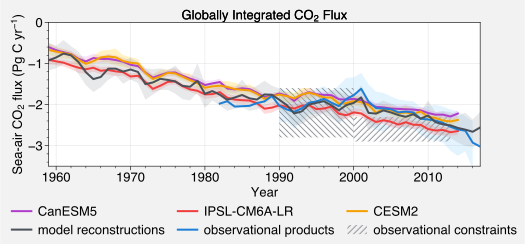

In [394]:
plot.rc.small = 13
plot.rc.large = 13
plot.rc['legend.frameon'] = False

f, ax = plot.subplots(axwidth=6, aspect=3, legend='b')


# ============
# OBSERVATIONS
# ============
obs = process_observations()
obs = obs.rename({'time': 'year'})
# fan for only 1990-2016 where we have 5 or more obs
plot_fan(obs.load().sel(year=slice(1990, 2016)), ax, facecolor='blue2', zorder=0, alpha=0.3)
obsH, = obs.mean('member').plot(ax=ax, color='blue7', linewidth=2, zorder=4, label='observational products')


# ===============
# CMIP6 ENSEMBLES
# ===============
# CanESM5 fan
canesm = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/CMIP6/CanESM5*p1*.nc', 
                           concat_dim='member')['fgco2'].sel(year=slice(1959, 2017))
plot_fan(canesm, ax, facecolor='grape3', zorder=1, alpha=0.3,)
canH, = canesm.mean('member').plot(ax=ax, color='grape7', linewidth=2, label='CanESM5')

# IPSL fan
ipsl = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/CMIP6/IPSL*.nc',
                         concat_dim='member')['fgco2'].sel(year=slice(1959, 2017))
plot_fan(ipsl, ax, facecolor='red4', zorder=1, alpha=0.3,)
ipslH, = ipsl.mean('member').plot(ax=ax, color='red7', linewidth=2, label='IPSL-CM6A-LR')

# CESM fan
cesm = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/CMIP6/CESM*.nc',
                         concat_dim='member')['fgco2'].sel(year=slice(1959, 2017))
plot_fan(cesm, ax, facecolor='yellow4', zorder=1, alpha=0.3, edgecolor=None)
cesmH, = cesm.mean('member').plot(ax=ax, color='yellow7', linewidth=2, label='CESM2')

# ===============
# RECONSTRUCTIONS
# ===============
omip = process_reconstructions()
omip = omip.rename({'time': 'year'})
# fan for OMIP (only cover where we have 8 or more reconstructions)
plot_fan(omip.load().sel(year=slice(1957, 2017)), ax, facecolor='gray5', zorder=1, alpha=0.3)
oH, = omip.mean('member').plot(ax=ax, color='gray7', linewidth=2, zorder=4, label='model reconstructions')

# =========================
# OBSERVATIONAL CONSTRAINTS
# =========================
# First constraint from Nikki's code.
ax.add_patch(Rectangle((1990, -2.8), 10, 1.2, linewidth=0, fill=None, hatch='\\\\\\\\', zorder=0, color='gray7'),)

# Gruber paper
# 2000 - 2013. 2.6 +/- 0.3 PgC/yr
constH = ax.add_patch(Rectangle((2000, -2.9), 13, 0.6, linewidth=0, fill=None, hatch='////', zorder=0, color='gray7', label='observational constraints'))


# ==========
# AESTHETICS
# ==========
f.bottompanel.legend([canH, ipslH, cesmH, oH, obsH, constH])

# Aesthetics
ax.format(xlim=[1959, 2017], ylabel='Sea-air CO$_{2}$ flux (Pg C yr$^{-1}$)',
          xlabel='Year', title='Globally Integrated CO$_{2}$ Flux',
          ylim=[-3.5, 0])

#f.save('fanchart_global.png', dpi=300, transparent=False)

# Southern Ocean Only